In [ ]:
# !pip install numpy pandas seaborn matplotlib scikit-learn safetensors
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# # reben requiring python > 3.9  but < 3.12
# !pip install git+https://git.tu-berlin.de/rsim/reben-training-scripts.git
# !pip install configilm torchsummary

In [37]:
import os
import time
from tempfile import TemporaryDirectory
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import rasterio

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoImageProcessor, ConvNextV2Model
import timm

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

import xgboost as xgb

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Train model on wealth index directly

**direct vit base** seems to give most reasonable looking results.

In [153]:
class VitBaseForRegression(nn.Module):
    def __init__(self, base_model):
        super(VitBaseForRegression, self).__init__()
        self.backbone = base_model
        # Add a regression head
        self.fc = nn.Sequential(
            nn.Linear(base_model.num_features, 1),
            nn.Sigmoid()
        )

        # Freeze the weights of the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = VitBaseForRegression(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [154]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    # transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms
test_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
    'test': test_transform
}

In [155]:
# Load target information
target_path = 'data'
df_target_raw = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth_Index':'target'})
df_target_raw['filename'] = df_target_raw['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target_raw.drop(columns='DHSCLUST', inplace=True)
df_target_raw = df_target_raw.astype({'target':'float32'})

In [156]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [157]:
# Load the full dataset
df_target = df_target_raw.copy()
image_folder = 'data/daysat/2022/'

# Perform train test split
ind_training, ind_test = train_test_split(df_target.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

# MinMaxScale to target
scaler = MinMaxScaler()
df_target.loc[ind_train,'target'] = scaler.fit_transform(df_target.loc[ind_train,['target']])
df_target.loc[ind_val,'target'] = scaler.transform(df_target.loc[ind_val,['target']])
df_target.loc[ind_test,'target'] = scaler.transform(df_target.loc[ind_test,['target']])

# Create datasets
train_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_train,:].reset_index(drop=True),transform=data_transforms['train'])
val_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_val,:].reset_index(drop=True),transform=data_transforms['val'])
test_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_test,:].reset_index(drop=True),transform=data_transforms['test'])

# Determine the sizes for the different datasets
total_size, train_val_size, train_size, val_size, test_size = len(df_target), len(ind_train) + len(ind_val), len(ind_train), len(ind_val), len(ind_test)
dataset_sizes = {'train':train_size, 'val':val_size, 'test': test_size}

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4),
    'test': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [158]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([num_epochs]), 'val':np.zeros([num_epochs])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 0m 23s


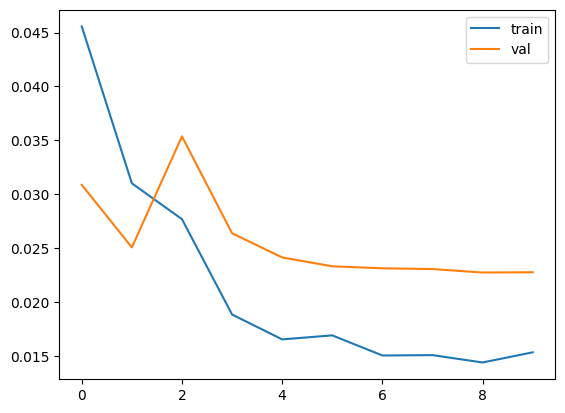

In [159]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10,verbose=0,plot_curves=True)

In [160]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

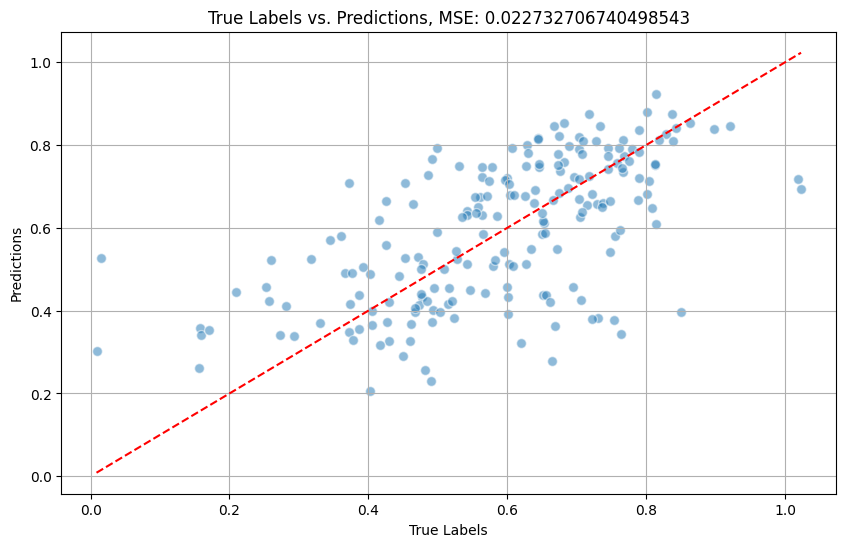

In [161]:
import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.show()

### Train model on nightlight

As before, direct vit base seems to be the best approach.

In [134]:
class VitBaseForRegression2(nn.Module):
    def __init__(self, base_model):
        super(VitBaseForRegression2, self).__init__()
        self.backbone = base_model
        # Add a regression head
        self.fc = nn.Sequential(
            nn.Linear(base_model.num_features, 512),  # First layer
            nn.BatchNorm1d(512),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            nn.Dropout(0.3),                          # Dropout for regularization
            
            nn.Linear(512, 256),                      # Second layer
            nn.BatchNorm1d(256),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            nn.Dropout(0.3),                          # Dropout for regularization
            
            nn.Linear(256, 128),                      # Third layer
            nn.BatchNorm1d(128),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            
            nn.Linear(128, 1),                        # Output layer
        )
        
        # Freeze the weights of the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = VitBaseForRegression2(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.00001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [135]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    # transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms
test_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
    'test': test_transform
}

In [136]:
# Load target information, log transform then min max scale
target_path = 'data'
df_target_raw = pd.read_csv(os.path.join(target_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_target_raw['filename'] = df_target_raw['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target_raw = df_target_raw[['filename','target']]
df_target_raw = df_target_raw.astype({'target':'float32'})

In [137]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target


In [138]:
# Load the full dataset
df_target = df_target_raw.copy()
image_folder = 'data/daysat/2022/'

# Perform train test split
ind_training, ind_test = train_test_split(df_target.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

# # MinMaxScale + log to target
# scaler = MinMaxScaler()
# df_target.loc[ind_train,'target'] = scaler.fit_transform(np.log(df_target.loc[ind_train,['target']]))
# df_target.loc[ind_val,'target'] = scaler.transform(np.log(df_target.loc[ind_val,['target']]))
# df_target.loc[ind_test,'target'] = scaler.transform(np.log(df_target.loc[ind_test,['target']]))

# # log transform target
# df_target.loc[ind_train,'target'] = np.log(df_target.loc[ind_train,['target']])
# df_target.loc[ind_val,'target'] = np.log(df_target.loc[ind_val,['target']])
# df_target.loc[ind_test,'target'] = np.log(df_target.loc[ind_test,['target']])

# Create datasets
train_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_train,:].reset_index(drop=True),transform=data_transforms['train'])
val_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_val,:].reset_index(drop=True),transform=data_transforms['val'])
test_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_test,:].reset_index(drop=True),transform=data_transforms['test'])

# Determine the sizes for the different datasets
total_size, train_val_size, train_size, val_size, test_size = len(df_target), len(ind_train) + len(ind_val), len(ind_train), len(ind_val), len(ind_test)
dataset_sizes = {'train':train_size, 'val':val_size, 'test': test_size}

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4,drop_last=True),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4,drop_last=True),
    'test': DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4,drop_last=True)
}

In [139]:
# Training code
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()
    df = pd.DataFrame({'train':np.zeros([num_epochs]), 'val':np.zeros([num_epochs])})
    
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 0m 23s


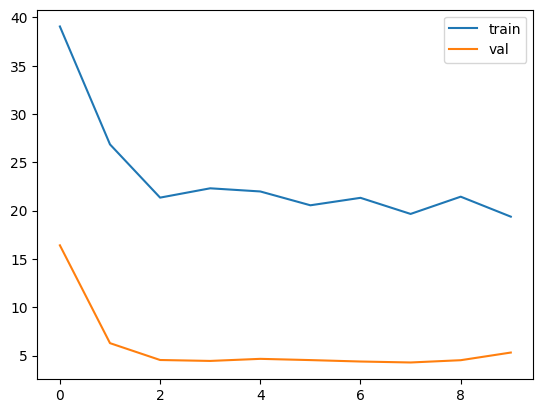

In [140]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10,verbose=0,plot_curves=True)

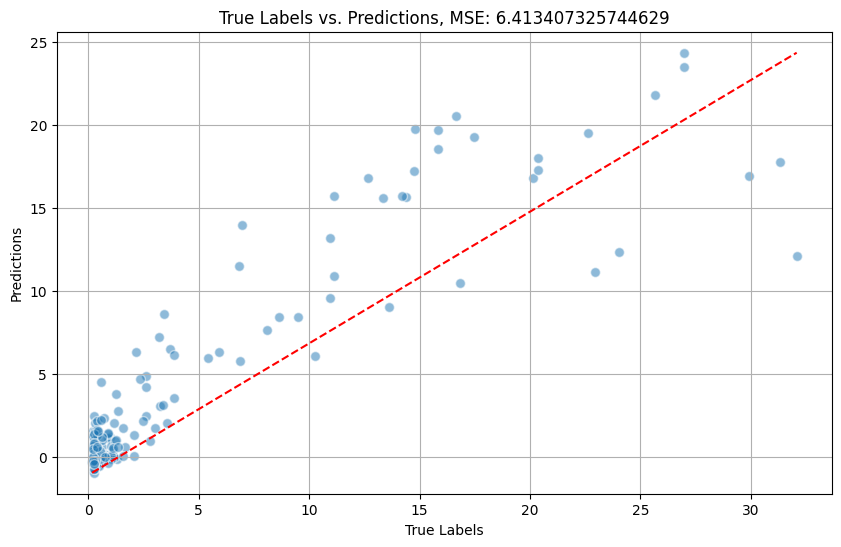

In [142]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_outputs), max(all_outputs)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

### Using daytime sat as additional feature

vit base seems to work best. tried for:
1. bigearthnet vit base vs direct vit base
2. log y, minmaxscale(log y), larger fc network, and larger fc network + minmaxscale(log y).

note: single linear layer ones need sigmoid to prevent exploding gradients

decided on:
1. daysat direct as additional feature - direct vit base + small network + sigmoid
2. transfer model as additional feature - direct vit base + larger fc network as additional feature

daysat direct conclusion --> better to get feature directly from vit base for training xgboost.

#### daysat direct on xgboost - direct feature extraction from vit base

Using first 50 components probably best, but not sure if really makes a big difference. performs better than using trained MLP head (below).

##### Quick run with some PCA

In [2]:
# Load data
target_path = 'data'
df_target_raw = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth_Index':'target'})
df_target_raw['filename'] = df_target_raw['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target_raw.drop(columns='DHSCLUST', inplace=True)
df_target_raw = df_target_raw.astype({'target':'float32'})

# Perform train test split
ind_training, ind_test = train_test_split(df_target_raw.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

# Load the full dataset
df_target = df_target_raw.copy()
image_folder = 'data/daysat/2022/'

# MinMaxScale to target
scaler = MinMaxScaler()
df_target.loc[ind_train.union(ind_val),'target'] = scaler.fit_transform(df_target.loc[ind_train.union(ind_val),['target']])
df_target.loc[ind_test,'target'] = scaler.transform(df_target.loc[ind_test,['target']])

In [7]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create datasets
train_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_train,:].reset_index(drop=True),transform=model_transforms)
val_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_val,:].reset_index(drop=True),transform=model_transforms)
test_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_test,:].reset_index(drop=True),transform=model_transforms)

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)
}

# Extract image features
model_base.eval()  # Set the model to evaluation mode

train_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['train']:
        inputs = inputs
        outputs = model_base(inputs)
        train_img_feat.append(outputs.cpu().numpy())
train_img_feat_raw = np.concatenate(train_img_feat, axis=0)

val_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs
        outputs = model_base(inputs)
        val_img_feat.append(outputs.cpu().numpy())
val_img_feat_raw = np.concatenate(val_img_feat, axis=0)

test_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs
        outputs = model_base(inputs)
        test_img_feat.append(outputs.cpu().numpy())
test_img_feat_raw = np.concatenate(test_img_feat, axis=0)

In [8]:
# Create copies of original
train_img_feat = train_img_feat_raw.copy()
val_img_feat = val_img_feat_raw.copy()
test_img_feat = test_img_feat_raw.copy()

# Scale before PCA
scaler_img = StandardScaler()
scaler_img.fit(np.vstack([train_img_feat,val_img_feat]))
train_img_feat = scaler_img.transform(train_img_feat)
val_img_feat = scaler_img.transform(val_img_feat)
test_img_feat = scaler_img.transform(test_img_feat)

# Perform PCA
pca_img = PCA(n_components=40)
pca_img.fit(np.vstack([train_img_feat,val_img_feat]))
print(np.sum(pca_img.explained_variance_ratio_))
train_img_feat = pca_img.transform(train_img_feat)
val_img_feat = pca_img.transform(val_img_feat)
test_img_feat = pca_img.transform(test_img_feat)

0.6321393


In [9]:
# Get targets
y_train = df_target.loc[ind_train,'target']
y_val = df_target.loc[ind_val,'target']
y_test = df_target.loc[ind_test,'target']

# Get other features
datapath = "data/"
X_all = pd.read_csv(os.path.join(datapath,'X.csv'))
X_all.drop(columns=['DHSCLUST'],inplace=True)
X_train = X_all.loc[ind_train,:]
X_val = X_all.loc[ind_val,:]
X_test = X_all.loc[ind_test,:]

# Get image features
X_train_img = pd.concat([X_train,
                     pd.DataFrame(train_img_feat,
                                  columns=[f'img_{i}' for i in range(train_img_feat.shape[1])],
                                  index=X_train.index)],
                    axis=1)
X_val_img = pd.concat([X_val,
                     pd.DataFrame(val_img_feat,
                                  columns=[f'img_{i}' for i in range(val_img_feat.shape[1])],
                                  index=X_val.index)],
                    axis=1)
X_test_img = pd.concat([X_test,
                     pd.DataFrame(test_img_feat,
                                  columns=[f'img_{i}' for i in range(test_img_feat.shape[1])],
                                  index=X_test.index)],
                    axis=1)

Testing performance
MSE: 0.0146


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

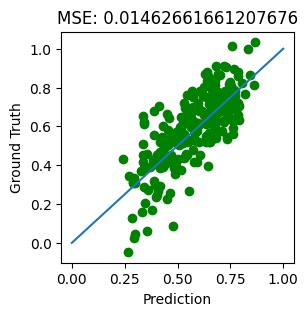

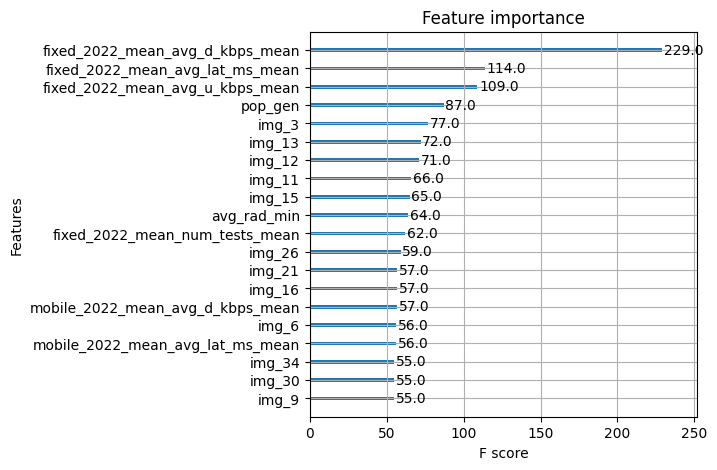

In [10]:
# After quick grid search below
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

model_xgb_base = xgb.XGBRegressor(**params)
model_xgb_base.fit(pd.concat([X_train_img,X_val_img],axis=0), np.hstack([y_train,y_val]))

# model_xgb_reg.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
pred = model_xgb_base.predict(X_test_img)
mse = mean_squared_error(y_test,pred)
print('Testing performance')
print(f'MSE: {mse:.4f}')

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(pred,y_test, c='g')
ax.plot([0,1],[0,1])
ax.set_title(f'MSE: {mse}')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth');

fig2, ax2 =plt.subplots(1,1,figsize=(5,5))
xgb.plot_importance(model_xgb_base,max_num_features=20,ax=ax2)

Testing performance
MSE: 0.0152


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

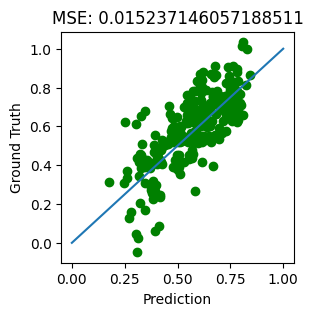

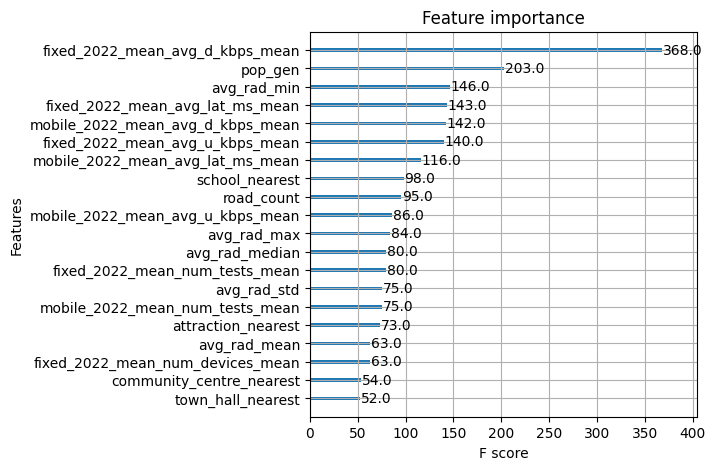

In [21]:
# After quick grid search below
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

model_xgb_base = xgb.XGBRegressor(**params)
model_xgb_base.fit(pd.concat([X_train,X_val],axis=0), np.hstack([y_train,y_val]))

# model_xgb_reg.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
pred = model_xgb_base.predict(X_test)
mse = mean_squared_error(y_test,pred)
print('Testing performance')
print(f'MSE: {mse:.4f}')

fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.scatter(pred,y_test, c='g')
ax.plot([0,1],[0,1])
ax.set_title(f'MSE: {mse}')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth');

fig2, ax2 =plt.subplots(1,1,figsize=(5,5))
xgb.plot_importance(model_xgb_base,max_num_features=20,ax=ax2)

##### Experiment with different number of PCA components

In [11]:
mses = []
for ncomp in range(10,400,5):
    # Create copies of original
    train_img_feat = train_img_feat_raw.copy()
    val_img_feat = val_img_feat_raw.copy()
    test_img_feat = test_img_feat_raw.copy()
    
    # Scale before PCA
    scaler_img = StandardScaler()
    scaler_img.fit(np.vstack([train_img_feat,val_img_feat]))
    train_img_feat = scaler_img.transform(train_img_feat)
    val_img_feat = scaler_img.transform(val_img_feat)
    test_img_feat = scaler_img.transform(test_img_feat)
    
    # Perform PCA
    pca_img = PCA(n_components=ncomp)
    pca_img.fit(np.vstack([train_img_feat,val_img_feat]))
    train_img_feat = pca_img.transform(train_img_feat)
    val_img_feat = pca_img.transform(val_img_feat)
    test_img_feat = pca_img.transform(test_img_feat)

    # Get targets
    y_train = df_target.loc[ind_train,'target']
    y_val = df_target.loc[ind_val,'target']
    y_test = df_target.loc[ind_test,'target']
    
    # Get other features
    datapath = "data/"
    X_all = pd.read_csv(os.path.join(datapath,'X.csv'))
    X_all.drop(columns=['DHSCLUST'],inplace=True)
    X_train = X_all.loc[ind_train,:]
    X_val = X_all.loc[ind_val,:]
    X_test = X_all.loc[ind_test,:]
    
    # Get image features
    X_train_img = pd.concat([X_train,
                         pd.DataFrame(train_img_feat,
                                      columns=[f'img_{i}' for i in range(train_img_feat.shape[1])],
                                      index=X_train.index)],
                        axis=1)
    X_val_img = pd.concat([X_val,
                         pd.DataFrame(val_img_feat,
                                      columns=[f'img_{i}' for i in range(val_img_feat.shape[1])],
                                      index=X_val.index)],
                        axis=1)
    X_test_img = pd.concat([X_test,
                         pd.DataFrame(test_img_feat,
                                      columns=[f'img_{i}' for i in range(test_img_feat.shape[1])],
                                      index=X_test.index)],
                        axis=1)
    
    # After quick grid search below
    params = {
        'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
        'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
        'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
    }
    
    model_xgb_base = xgb.XGBRegressor(**params)
    model_xgb_base.fit(pd.concat([X_train_img,X_val_img],axis=0), np.hstack([y_train,y_val]))
    
    # model_xgb_reg.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
    pred = model_xgb_base.predict(X_test_img)
    mse = mean_squared_error(y_test,pred)
    mses.append(mse)

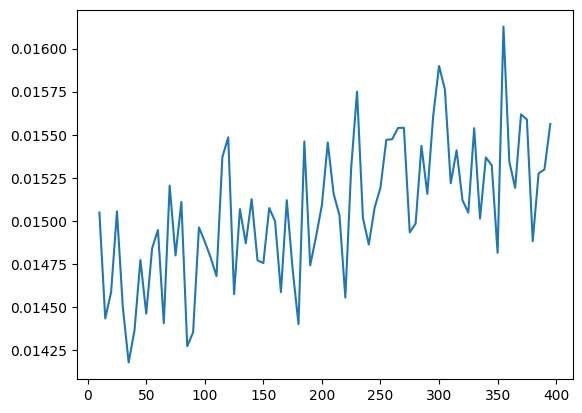

In [17]:
plt.plot(range(10,400,5),np.array(mses))

(0.0, 0.2)

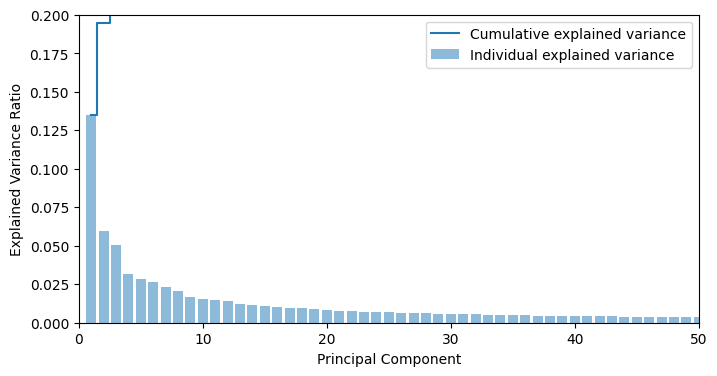

In [20]:
# Explained variance ratio (as a proportion of total variance)
explained_variance_ratio = pca_img.explained_variance_ratio_
# print("Explained Variance Ratio:", explained_variance_ratio)

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
# print("Cumulative Explained Variance:", cumulative_explained_variance)

# Plot the explained variance ratio
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.xlim([0,50])
plt.ylim([0,0.2])

##### use ncomp=50

In [97]:
# Load data
target_path = 'data'
df_target_raw = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth_Index':'target'})
df_target_raw['filename'] = df_target_raw['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target_raw.drop(columns='DHSCLUST', inplace=True)
df_target_raw = df_target_raw.astype({'target':'float32'})

# Perform train test split
ind_training, ind_test = train_test_split(df_target_raw.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

# Load the full dataset
df_target = df_target_raw.copy()
image_folder = 'data/daysat/2022/'

# MinMaxScale to target
scaler = MinMaxScaler()
df_target.loc[ind_train.union(ind_val),'target'] = scaler.fit_transform(df_target.loc[ind_train.union(ind_val),['target']])
df_target.loc[ind_test,'target'] = scaler.transform(df_target.loc[ind_test,['target']])

In [98]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create datasets
train_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_train,:].reset_index(drop=True),transform=model_transforms)
val_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_val,:].reset_index(drop=True),transform=model_transforms)
test_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target.loc[ind_test,:].reset_index(drop=True),transform=model_transforms)

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)
}

# Extract image features
model_base.eval()  # Set the model to evaluation mode

train_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['train']:
        inputs = inputs
        outputs = model_base(inputs)
        train_img_feat.append(outputs.cpu().numpy())
train_img_feat_raw = np.concatenate(train_img_feat, axis=0)

val_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs
        outputs = model_base(inputs)
        val_img_feat.append(outputs.cpu().numpy())
val_img_feat_raw = np.concatenate(val_img_feat, axis=0)

test_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs
        outputs = model_base(inputs)
        test_img_feat.append(outputs.cpu().numpy())
test_img_feat_raw = np.concatenate(test_img_feat, axis=0)

In [99]:
# Create copies of original
train_img_feat = train_img_feat_raw.copy()
val_img_feat = val_img_feat_raw.copy()
test_img_feat = test_img_feat_raw.copy()

# Scale before PCA
scaler_img = StandardScaler()
scaler_img.fit(np.vstack([train_img_feat,val_img_feat]))
train_img_feat = scaler_img.transform(train_img_feat)
val_img_feat = scaler_img.transform(val_img_feat)
test_img_feat = scaler_img.transform(test_img_feat)

# Perform PCA
pca_img = PCA(n_components=50)
pca_img.fit(np.vstack([train_img_feat,val_img_feat]))
print(np.sum(pca_img.explained_variance_ratio_))
train_img_feat = pca_img.transform(train_img_feat)
val_img_feat = pca_img.transform(val_img_feat)
test_img_feat = pca_img.transform(test_img_feat)

0.67083555


In [100]:
# Get targets
y_train = df_target.loc[ind_train,'target']
y_val = df_target.loc[ind_val,'target']
y_test = df_target.loc[ind_test,'target']

# Get other features
datapath = "data/"
X_all = pd.read_csv(os.path.join(datapath,'X.csv'))
X_all.drop(columns=['DHSCLUST'],inplace=True)
X_train = X_all.loc[ind_train,:]
X_val = X_all.loc[ind_val,:]
X_test = X_all.loc[ind_test,:]

# Get image features
X_train_img = pd.concat([X_train,
                     pd.DataFrame(train_img_feat,
                                  columns=[f'img_{i}' for i in range(train_img_feat.shape[1])],
                                  index=X_train.index)],
                    axis=1)
X_val_img = pd.concat([X_val,
                     pd.DataFrame(val_img_feat,
                                  columns=[f'img_{i}' for i in range(val_img_feat.shape[1])],
                                  index=X_val.index)],
                    axis=1)
X_test_img = pd.concat([X_test,
                     pd.DataFrame(test_img_feat,
                                  columns=[f'img_{i}' for i in range(test_img_feat.shape[1])],
                                  index=X_test.index)],
                    axis=1)

In [101]:
image_feature_names = [col for col in X_train_img.columns if 'img' in col]
HRSL_feature_names = ['pop_gen']
OOKLA_feature_names = ['fixed_2022_mean_avg_d_kbps_mean','fixed_2022_mean_avg_u_kbps_mean',
                       'fixed_2022_mean_avg_lat_ms_mean','fixed_2022_mean_num_tests_mean',
                       'fixed_2022_mean_num_devices_mean','mobile_2022_mean_avg_d_kbps_mean',
                       'mobile_2022_mean_avg_u_kbps_mean','mobile_2022_mean_avg_lat_ms_mean',
                       'mobile_2022_mean_num_tests_mean','mobile_2022_mean_num_devices_mean']
nightlight_feature_names = ['avg_rad_min','avg_rad_max','avg_rad_mean',
                            'avg_rad_std','avg_rad_median']
non_OSM_feature_names = image_feature_names+HRSL_feature_names+OOKLA_feature_names+nightlight_feature_names
non_OSM_n_img_feature_names = HRSL_feature_names+OOKLA_feature_names+nightlight_feature_names
OSM_feature_names = list(set(X_trainval.columns)-set(non_OSM_feature_names))

In [102]:
all_feature_groups = {'OOKLA':OOKLA_feature_names,
                      'nightlight':nightlight_feature_names,
                      'image':image_feature_names,
                      'HRSL':HRSL_feature_names,
                      'OSM':OSM_feature_names}

# Generate all possible combinations of the items
combinations = []
for r in range(1, len(all_feature_groups) + 1):
    for combination in itertools.combinations(all_feature_groups.keys(), r):
        # Create a dictionary to represent the row
        row = {'OOKLA':0, 'nightlight':0, 'image':0, 'HRSL':0, 'OSM':0}
        combined_list = []
        
        for item in combination:
            row[item] = 1  # Mark the presence of this list
            combined_list.extend(all_feature_groups[item])  # Concatenate the lists
        
        # Add a label for the y-tick
        row['Label'] = ','.join(combination)
        
        row['feature_names'] = combined_list  # Store the combined list as well
        combinations.append(row)

df = pd.DataFrame(combinations)
df['MSE'] = 0

In [103]:
# After quick grid search below
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

for i, feature_names in enumerate(df['feature_names']):
    model_xgb_base = xgb.XGBRegressor(**params)
    # model_xgb_base.fit(X_trainval_img[feature_names], y_trainval)
    model_xgb_base.fit(pd.concat([X_train_img,X_val_img],axis=0)[feature_names], np.hstack([y_train,y_val]))
    
    # model_xgb_reg.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
    pred = model_xgb_base.predict(X_test_img[feature_names])
    
    mse = mean_squared_error(y_test,pred)
    df.loc[i,'MSE'] = mse

/tmp/ipykernel_64539/2968716443.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.018633732572197914' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i,'MSE'] = mse


In [104]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names'])[df['image']==1].sort_values('MSE')

,Label,MSE
19,"OOKLA,image,OSM",0.014401
13,"image,OSM",0.014992
28,"OOKLA,image,HRSL,OSM",0.015011
26,"OOKLA,nightlight,image,OSM",0.015163
24,"image,HRSL,OSM",0.015221
22,"nightlight,image,OSM",0.015279
30,"OOKLA,nightlight,image,HRSL,OSM",0.015318
29,"nightlight,image,HRSL,OSM",0.015543
18,"OOKLA,image,HRSL",0.016835
25,"OOKLA,nightlight,image,HRSL",0.016844


In [105]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names']).sort_values('MSE')

,Label,MSE
19,"OOKLA,image,OSM",0.014401
13,"image,OSM",0.014992
28,"OOKLA,image,HRSL,OSM",0.015011
8,"OOKLA,OSM",0.015133
26,"OOKLA,nightlight,image,OSM",0.015163
27,"OOKLA,nightlight,HRSL,OSM",0.015194
24,"image,HRSL,OSM",0.015221
22,"nightlight,image,OSM",0.015279
30,"OOKLA,nightlight,image,HRSL,OSM",0.015318
20,"OOKLA,HRSL,OSM",0.015376


#### daysat direct on xgboost - vit feature extraction + trained MLP

feature extraction with training to predict wealth, but feels like not much improvement either.

In [83]:
# Load data
target_path = 'data'
df_target_raw = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth_Index':'target'})
df_target_raw['filename'] = df_target_raw['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target_raw.drop(columns='DHSCLUST', inplace=True)
df_target_raw = df_target_raw.astype({'target':'float32'})

# Perform train test split
ind_training, ind_test = train_test_split(df_target_raw.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

# Load the full dataset
df_target = df_target_raw.copy()
image_folder = 'data/daysat/2022/'

# MinMaxScale to target
scaler = MinMaxScaler()
df_target.loc[ind_train.union(ind_val),'target'] = scaler.fit_transform(df_target.loc[ind_train.union(ind_val),['target']])
df_target.loc[ind_test,'target'] = scaler.transform(df_target.loc[ind_test,['target']])

In [84]:
class VitBaseForRegression(nn.Module):
    def __init__(self, base_model):
        super(VitBaseForRegression, self).__init__()
        self.backbone = base_model
        # Add a regression head
        self.fc = nn.Sequential(
            nn.Linear(base_model.num_features, 1),
            nn.Sigmoid()
        )

        # Freeze the weights of the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs


# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'trainval':np.zeros([num_epochs]), 'test':np.zeros([num_epochs])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['trainval', 'test']:
                if phase == 'trainval':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in trainval
                    with torch.set_grad_enabled(phase == 'trainval'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'trainval':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'trainval':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'test' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

In [85]:
# Create model
model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = VitBaseForRegression(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# transform
trainval_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    # transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

test_transform = model_transforms

data_transforms = {
    'trainval': trainval_transform,
    'test': test_transform
}

# Create datasets
trainval_dataset = RegressionDataset(image_folder=image_folder,
                                     targets_df=df_target.loc[ind_train.union(ind_val),:].reset_index(drop=True),
                                     transform=data_transforms['trainval'])
test_dataset = RegressionDataset(image_folder=image_folder,
                                 targets_df=df_target.loc[ind_test,:].reset_index(drop=True),
                                 transform=data_transforms['test'])

# Determine the sizes for the different datasets
total_size, trainval_size, train_size, val_size, test_size = len(df_target), len(ind_train) + len(ind_val), len(ind_train), len(ind_val), len(ind_test)
dataset_sizes = {'trainval':trainval_size, 'test': test_size}

# Create DataLoader instances
dataloaders = {
    'trainval': DataLoader(trainval_dataset, batch_size=8, shuffle=True, num_workers=4,drop_last=False),
    'trainval_eval': DataLoader(trainval_dataset, batch_size=8, shuffle=False, num_workers=4,drop_last=False),
    'test': DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, drop_last=False)
    
}

Training complete in 0m 27s


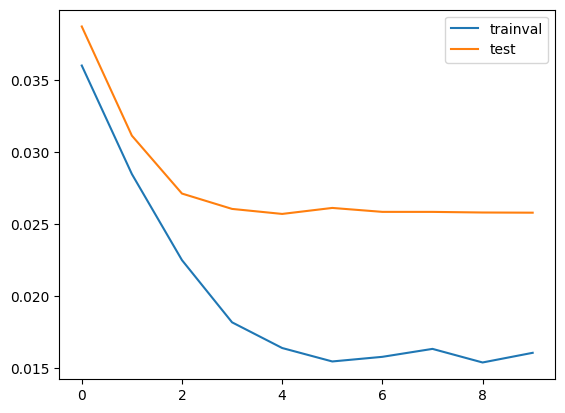

In [86]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10,verbose=0,plot_curves=True)

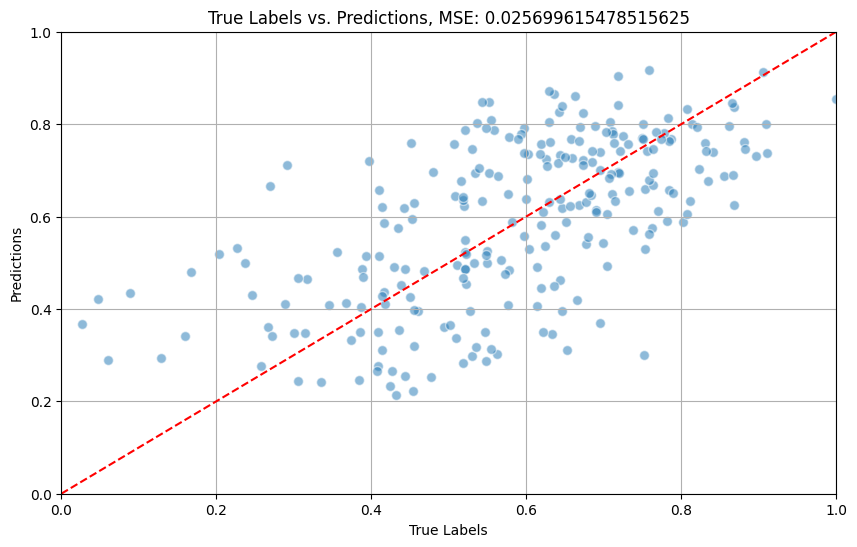

In [87]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1]);

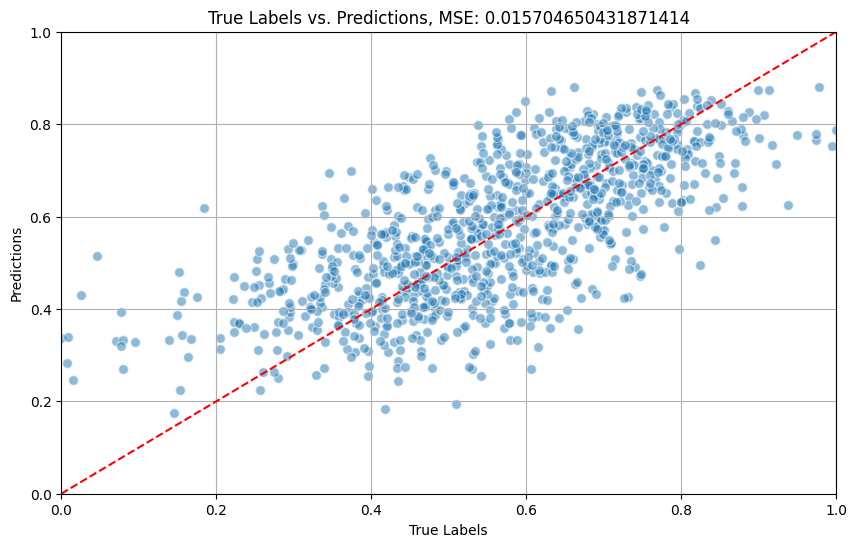

In [88]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['trainval_eval']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1]);

In [89]:
# Initialize lists to store the outputs and labels
return_nodes = {
    "fc.1": "lin_out"      # taking from this rather than from fc.0 seems better
}
model_reg_extractor = create_feature_extractor(model_reg, return_nodes=return_nodes)
model_reg_extractor.eval()  # Set the model to evaluation mode

all_outputs = []
with torch.no_grad():
    for inputs, labels in dataloaders['trainval_eval']:
        inputs = inputs.to(device)
        outputs = model_reg_extractor(inputs)
        all_outputs.append(outputs['lin_out'].squeeze().cpu().numpy())
trainval_img_feat = np.concatenate(all_outputs, axis=0)

all_outputs = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model_reg_extractor(inputs)
        all_outputs.append(outputs['lin_out'].squeeze().cpu().numpy())
test_img_feat = np.concatenate(all_outputs, axis=0)

In [90]:
# Get targets
y_trainval = df_target.loc[ind_train.union(ind_val),'target']
y_test = df_target.loc[ind_test,'target']

# Get other features
datapath = "data/"
X_all = pd.read_csv(os.path.join(datapath,'X.csv'))
X_all.drop(columns=['DHSCLUST'],inplace=True)
X_trainval = X_all.loc[ind_train.union(ind_val),:]
X_test = X_all.loc[ind_test,:]

# Get image features
X_trainval_img = pd.concat([X_trainval,
                     pd.DataFrame(trainval_img_feat,
                                  columns=['img'],
                                  index=X_trainval.index)],
                    axis=1)

X_test_img = pd.concat([X_test,
                     pd.DataFrame(test_img_feat,
                                  columns=['img'],
                                  index=X_test.index)],
                    axis=1)

In [91]:
image_feature_names = ['img']
HRSL_feature_names = ['pop_gen']
OOKLA_feature_names = ['fixed_2022_mean_avg_d_kbps_mean','fixed_2022_mean_avg_u_kbps_mean',
                       'fixed_2022_mean_avg_lat_ms_mean','fixed_2022_mean_num_tests_mean',
                       'fixed_2022_mean_num_devices_mean','mobile_2022_mean_avg_d_kbps_mean',
                       'mobile_2022_mean_avg_u_kbps_mean','mobile_2022_mean_avg_lat_ms_mean',
                       'mobile_2022_mean_num_tests_mean','mobile_2022_mean_num_devices_mean']
nightlight_feature_names = ['avg_rad_min','avg_rad_max','avg_rad_mean',
                            'avg_rad_std','avg_rad_median']
non_OSM_feature_names = image_feature_names+HRSL_feature_names+OOKLA_feature_names+nightlight_feature_names
non_OSM_n_img_feature_names = HRSL_feature_names+OOKLA_feature_names+nightlight_feature_names
OSM_feature_names = list(set(X_trainval.columns)-set(non_OSM_feature_names))

In [92]:
all_feature_groups = {'OOKLA':OOKLA_feature_names,
                      'nightlight':nightlight_feature_names,
                      'image':image_feature_names,
                      'HRSL':HRSL_feature_names,
                      'OSM':OSM_feature_names}

# Generate all possible combinations of the items
combinations = []
for r in range(1, len(all_feature_groups) + 1):
    for combination in itertools.combinations(all_feature_groups.keys(), r):
        # Create a dictionary to represent the row
        row = {'OOKLA':0, 'nightlight':0, 'image':0, 'HRSL':0, 'OSM':0}
        combined_list = []
        
        for item in combination:
            row[item] = 1  # Mark the presence of this list
            combined_list.extend(all_feature_groups[item])  # Concatenate the lists
        
        # Add a label for the y-tick
        row['Label'] = ','.join(combination)
        
        row['feature_names'] = combined_list  # Store the combined list as well
        combinations.append(row)

df = pd.DataFrame(combinations)
df['MSE'] = 0

In [93]:
# After quick grid search below
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

for i, feature_names in enumerate(df['feature_names']):
    model_xgb_base = xgb.XGBRegressor(**params)
    model_xgb_base.fit(X_trainval_img[feature_names], y_trainval)
    
    # model_xgb_reg.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
    pred = model_xgb_base.predict(X_test_img[feature_names])
    mse = mean_squared_error(y_test,pred)
    df.loc[i,'MSE'] = mse
    # print('Testing performance')
    # print(f'MSE: {mse:.4f}')
    
    # fig, ax = plt.subplots(1,1,figsize=(3,3))
    # ax.scatter(pred,y_test, c='g')
    # ax.plot([0,1],[0,1])
    # ax.set_title(f'MSE: {mse}')
    # ax.set_xlabel('Prediction')
    # ax.set_ylabel('Ground Truth');
    
    # fig2, ax2 =plt.subplots(1,1,figsize=(5,5))
    # xgb.plot_importance(model_xgb_base,max_num_features=20,ax=ax2)

/tmp/ipykernel_64539/3541641701.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.018633732572197914' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i,'MSE'] = mse


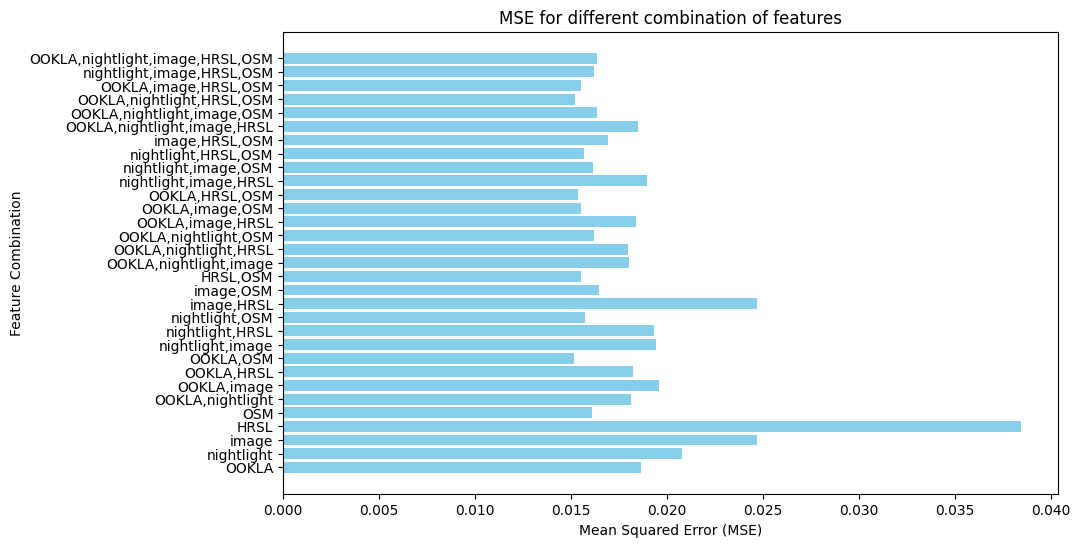

In [94]:
# Plotting
plt.figure(figsize=(10, 6))
plt.barh(df['Label'], df['MSE'], color='skyblue')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Feature Combination')
plt.title('MSE for different combination of features')

# Show the plot
plt.show()

In [95]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names'])[df['image']==1].sort_values('MSE')

,Label,MSE
28,"OOKLA,image,HRSL,OSM",0.015492
19,"OOKLA,image,OSM",0.015521
22,"nightlight,image,OSM",0.016146
29,"nightlight,image,HRSL,OSM",0.016204
26,"OOKLA,nightlight,image,OSM",0.016345
30,"OOKLA,nightlight,image,HRSL,OSM",0.016358
13,"image,OSM",0.016441
24,"image,HRSL,OSM",0.016935
15,"OOKLA,nightlight,image",0.018013
18,"OOKLA,image,HRSL",0.018367


In [96]:
df.drop(columns=['OOKLA','nightlight','image','HRSL','OSM','feature_names']).sort_values('MSE')

,Label,MSE
8,"OOKLA,OSM",0.015133
27,"OOKLA,nightlight,HRSL,OSM",0.015194
20,"OOKLA,HRSL,OSM",0.015376
28,"OOKLA,image,HRSL,OSM",0.015492
19,"OOKLA,image,OSM",0.015521
14,"HRSL,OSM",0.015535
23,"nightlight,HRSL,OSM",0.015648
11,"nightlight,OSM",0.015708
4,OSM,0.016075
22,"nightlight,image,OSM",0.016146


#### daysat direct on CNN